In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


## Dataset Overview

In [8]:
data = pd.read_csv('fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [9]:
#preview first 5 row of data
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [10]:
#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [11]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


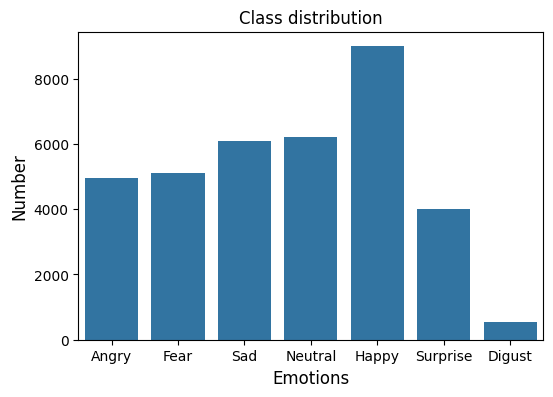

In [13]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(x='emotion', y='number', data=emotion_counts)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

#### Let's look at some images...

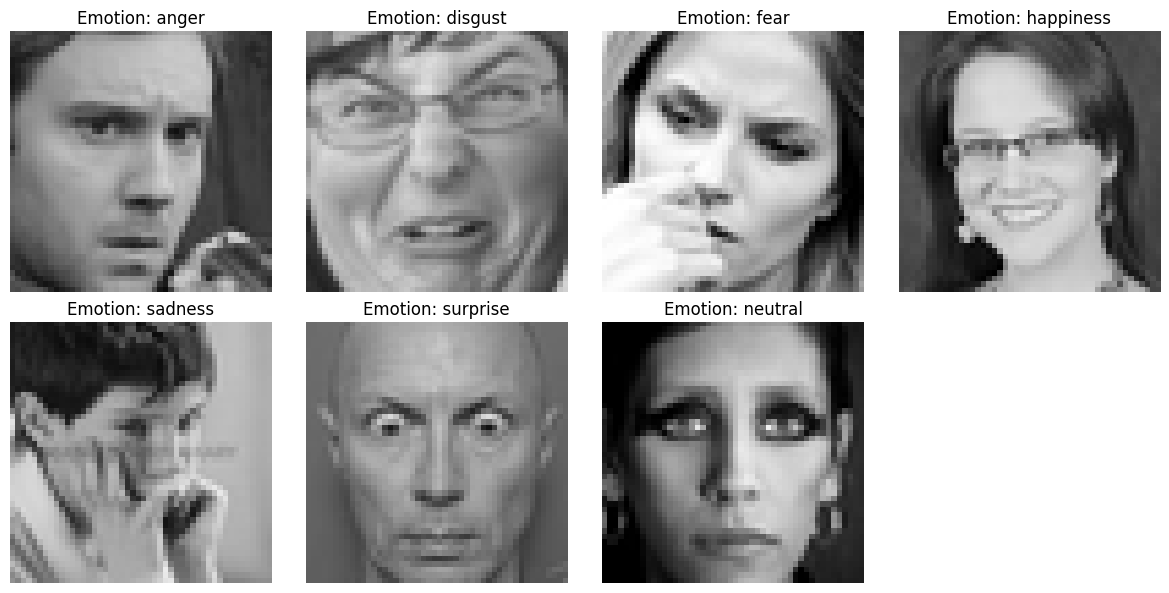

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define your emotion map
emotion_map = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

# Fix the function: return a tuple (image, emotion)
def row2image(row):
    pixels = row['pixels']
    emotion = emotion_map[row['emotion']]
    img = np.array(pixels.split(), dtype=np.uint8).reshape(48, 48)
    
    # Convert grayscale to 3-channel RGB
    image = np.stack([img] * 3, axis=-1)
    
    return image, emotion

# Plot one image per emotion
plt.figure(figsize=(12, 6))

for i in range(7):  # 0 to 6 (7 emotions)
    face = data[data['emotion'] == i].iloc[0]  # First image of each class
    img, emo = row2image(face)
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Emotion: {emo}")
    plt.axis('off')

plt.tight_layout()
plt.show()


----------------------------------------------------------------------------------
## Pre-processing data
#### Summary:
1. Splitting dataset into 3 parts: train, validation, test
1. Convert strings to lists of integers
1. Reshape to 48x48 and normalise grayscale image with 255.0
1. Perform one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

In [17]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


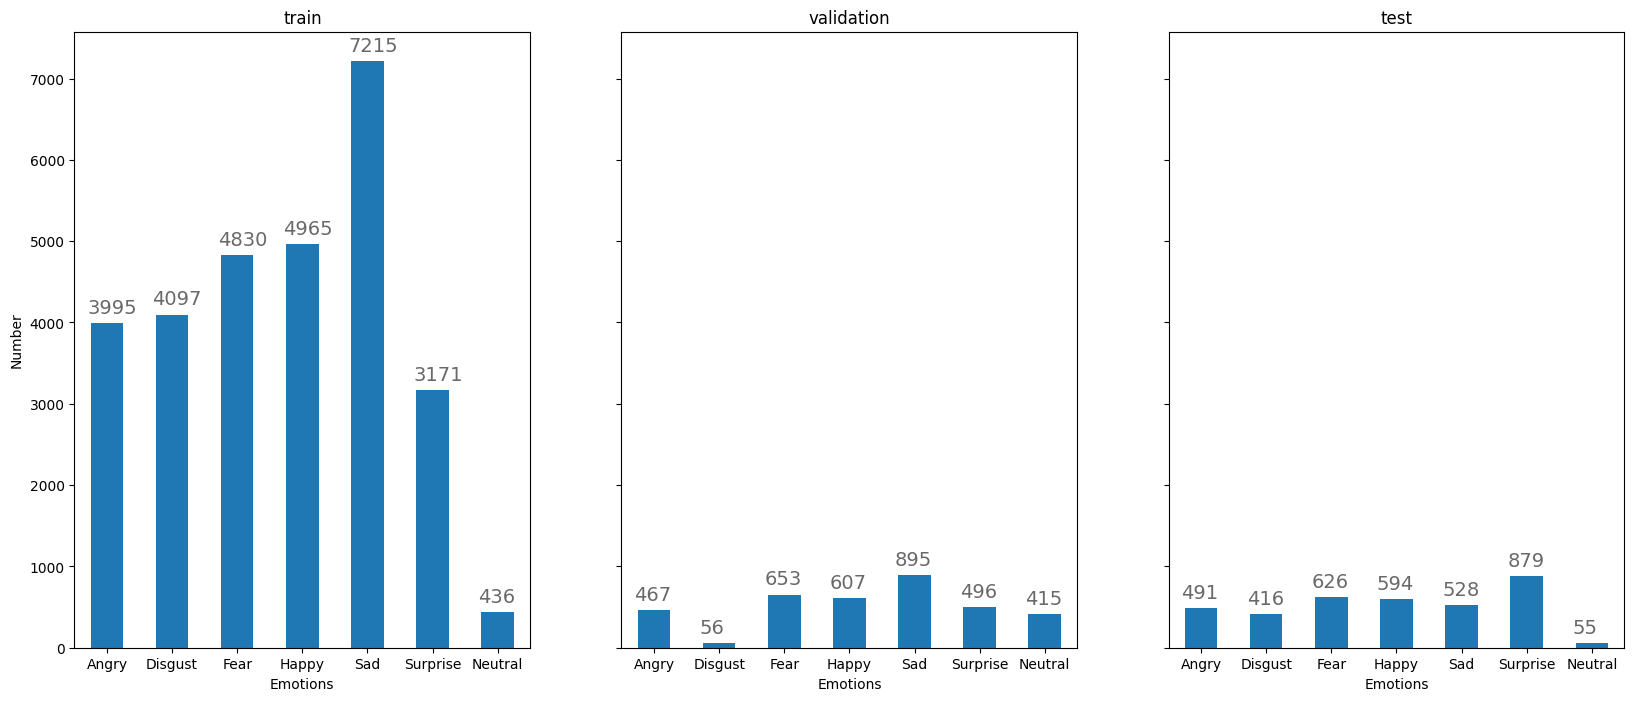

In [18]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

Notice that the later two subplots share the same y-axis with the first subplot. 

The size of **train**, **validation**, **test** are **80%**, **10%** and **10%**, respectively. 

The exact number of each class of these datasets are written on top of their x-axis bar. 

In [19]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 500
batch_size = 64
num_features = 64

In [21]:
import cv2

image_size = (64,64)

def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

def load_fer2013(df, dataName):
    pixels = df['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'), image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    faces = preprocess_input(faces)
    emotions = pd.get_dummies(df['emotion']).values
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(faces.shape, emotions.shape))
    return faces, emotions   

train_X, train_Y = load_fer2013(data_train, "train") #training data
val_X, val_Y     = load_fer2013(data_val, "val") #validation data
test_X, test_Y   = load_fer2013(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 64, 64, 1)
val _X shape: {},  val _Y shape: (3589, 64, 64, 1)
test _X shape: {},  test _Y shape: (3589, 64, 64, 1)


----------------------------------------------------------------------------------
## Building CNN Model

### CNN Architecture:  
* Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling 
* Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling 
* Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling 
* Flatten
* Dense -> BN -> Activation
* Dense -> BN -> Activation
* Dense -> BN -> Activation
* Output layer

In [23]:
from keras.layers import Input
from keras.layers import SeparableConv2D
from keras import layers
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

def big_XCEPTION(input_shape, num_classes):
    img_input = Input(input_shape)
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False)(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])
    x = Conv2D(num_classes, (3, 3),
               # kernel_regularizer=regularization,
               padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model

input_shape = (64, 64, 1)
num_classes = 7

    # model parameters/compilation
model = big_XCEPTION(input_shape, num_classes)
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 31, 31,    │        288 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 31, 31,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 31, 31,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 29, 29,    │     18,432 │ block1_conv1_act… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 29, 29,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 29, 29,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_4  │ (None, 29, 29,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 29, 29,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 29, 29,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_5  │ (None, 29, 29,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 29, 29,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 15, 15,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 15, 15,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 15, 15,    │          0 │ max_pooling2d_2[… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 15, 15,    │          0 │ add_2[0][0]     

 Total params: 208,871 (815.90 KB)

 Trainable params: 206,375 (806.15 KB)

 Non-trainable params: 2,496 (9.75 KB)

In [49]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

patience = 32

reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                              patience=int(patience/4), verbose=1)

es = EarlyStopping(monitor='val_loss', patience = patience, mode = 'min', restore_best_weights=True)

num_epochs = 25  # or however many you want (10–50 recommended for FER2013)

history = model.fit(
    data_generator.flow(train_X, train_Y, batch_size),
    steps_per_epoch=len(train_X) // batch_size,
    epochs=num_epochs,  # ✅ Add this line
    verbose=1,
    callbacks=[es, reduce_lr],
    validation_data=(val_X, val_Y)
)


Epoch 1/25
448/448 ━━━━━━━━━━━━━━━━━━━━ 158s 352ms/step - accuracy: 0.4415 - loss: 1.4567 - val_accuracy: 0.4533 - val_loss: 1.5189 - learning_rate: 0.0010
Epoch 2/25
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:54 390ms/step - accuracy: 0.5312 - loss: 1.1585

c:\Users\parde\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5312 - loss: 1.1585 - val_accuracy: 0.4642 - val_loss: 1.4819 - learning_rate: 0.0010
Epoch 3/25
448/448 ━━━━━━━━━━━━━━━━━━━━ 160s 357ms/step - accuracy: 0.4854 - loss: 1.3688 - val_accuracy: 0.4079 - val_loss: 1.9271 - learning_rate: 0.0010
Epoch 4/25
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4688 - loss: 1.4379 - val_accuracy: 0.4333 - val_loss: 1.7835 - learning_rate: 0.0010
Epoch 5/25
448/448 ━━━━━━━━━━━━━━━━━━━━ 149s 333ms/step - accuracy: 0.5052 - loss: 1.3070 - val_accuracy: 0.4564 - val_loss: 1.5065 - learning_rate: 0.0010
Epoch 6/25
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4844 - loss: 1.3664 - val_accuracy: 0.4670 - val_loss: 1.4373 - learning_rate: 0.0010
Epoch 7/25
448/448 ━━━━━━━━━━━━━━━━━━━━ 149s 333ms/step - accuracy: 0.5226 - loss: 1.2581 - val_accuracy: 0.4620 - val_loss: 1.5565 - learning_rate: 0.0010
Epoch 8/25
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4844 - loss: 1.1286 -

## Visualize Training Performance

In [50]:
history.history['accuracy']        # not 'acc'
history.history['val_accuracy']    # not 'val_acc'


[0.4533296227455139,
 0.4641961455345154,
 0.40791305899620056,
 0.43326830863952637,
 0.4563945531845093,
 0.4669824540615082,
 0.4619671106338501,
 0.4641961455345154,
 0.49066591262817383,
 0.48425745964050293,
 0.42908889055252075,
 0.44803565740585327,
 0.5344107151031494,
 0.5349679589271545,
 0.5394260287284851,
 0.5346893072128296,
 0.5391473770141602,
 0.5427695512771606,
 0.465310662984848,
 0.48397883772850037,
 0.5650599002838135,
 0.5672889351844788,
 0.5692393183708191,
 0.5756478309631348,
 0.5539147257804871]

In [51]:
print(history.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


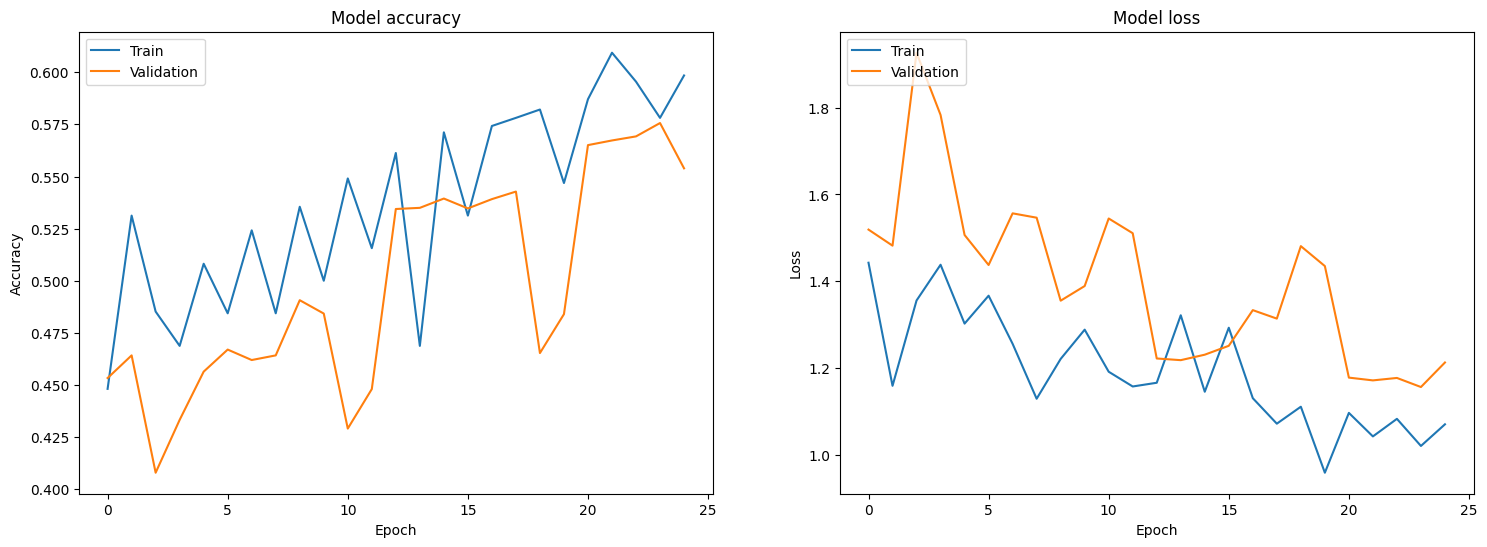

In [52]:
%matplotlib inline

fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluate Test Performance

In [57]:
import datetime
now = datetime.datetime.now()
acc_final = round(accuracy_score(test_true, test_pred),3)
current_now  = now.strftime("%Y-%m-%d_%H-%M-%S")

model_name_to_save = ('FERMo_{}_with_Acc-{}'.format(current_now,acc_final))
# Save model architecture to JSON
model_json = model.to_json()
model_name_to_save = f"Recognization"  # Assuming you already have acc and timestamp

with open(f"{model_name_to_save}.json", 'w') as json_file:
    json_file.write(model_json)

# ✅ Save weights with proper extension
model.save_weights(f"{model_name_to_save}.weights.h5")


In [58]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

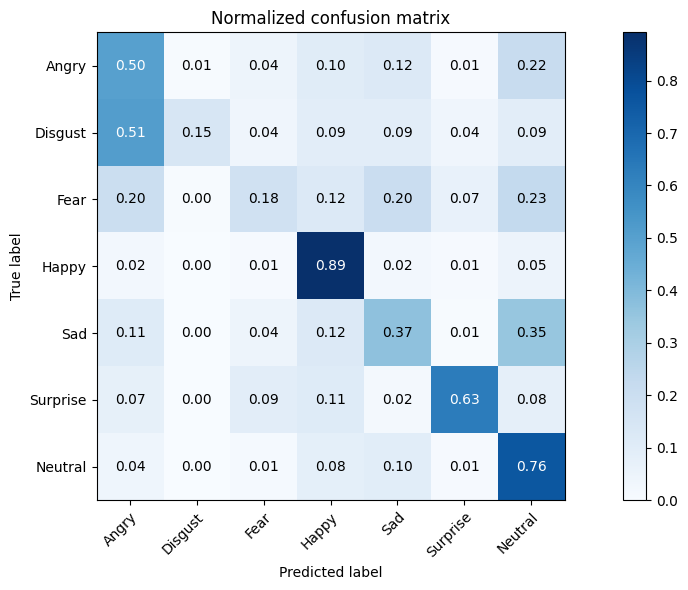

In [59]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
emotion_map = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

In [10]:
import numpy as np
import cv2
from keras.models import model_from_json
import matplotlib.pyplot as plt


In [11]:
# Load model
with open("FERMo_2025-07-10_19-34-26_with_Acc-0.581.json", "r") as json_file:
    model = model_from_json(json_file.read())

model.load_weights("Recognization.weights.h5")


In [12]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    img = cv2.resize(img, (64, 64))  # Resize to 64x64 (match model input)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=-1)  # shape: (64, 64, 1)
    img = np.expand_dims(img, axis=0)   # shape: (1, 64, 64, 1)
    return img


In [13]:
def predict_emotion(image_path):
    emotion_map = {
        0: 'anger',
        1: 'disgust',
        2: 'fear',
        3: 'happiness',
        4: 'sadness',
        5: 'surprise',
        6: 'neutral'
    }
    img = preprocess_image(image_path)
    preds = model.predict(img)
    predicted_index = np.argmax(preds)
    confidence = preds[0][predicted_index]
    print(f"Predicted Emotion: {emotion_map[predicted_index]} ({confidence*100:.2f}%)")

    # Show image with title
    plt.imshow(cv2.imread(image_path), cmap='gray')
    plt.title(f"{emotion_map[predicted_index]} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Predicted Emotion: happiness (38.35%)


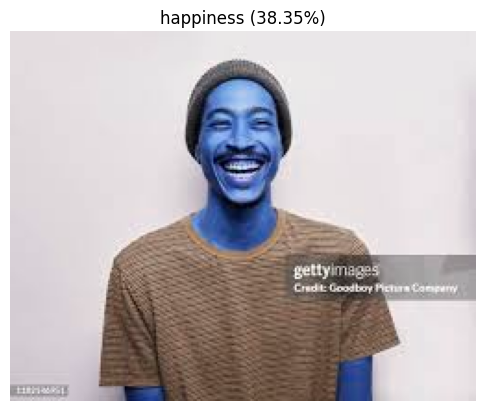

In [14]:
predict_emotion("happy.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Emotion: anger (55.69%)


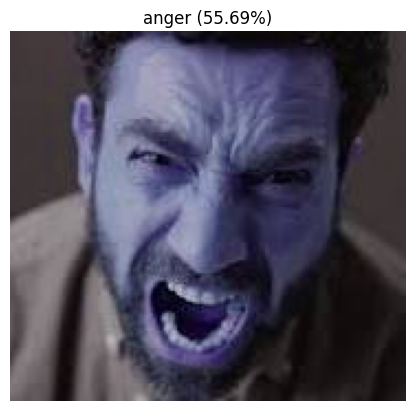

In [15]:
predict_emotion("anger.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Emotion: surprise (67.59%)


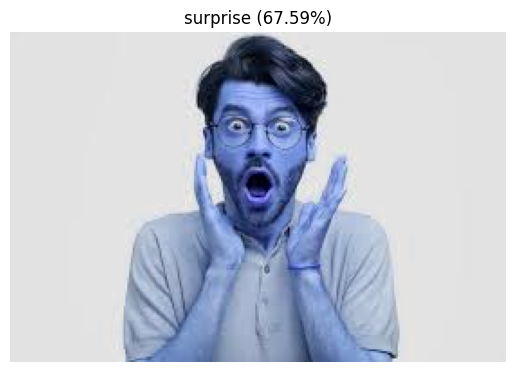

In [16]:
predict_emotion("suprise.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Emotion: neutral (63.46%)


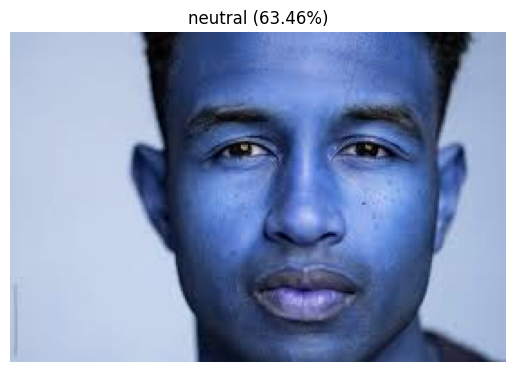

In [17]:
predict_emotion("neutral.png")